In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
import uncertainties.unumpy as un

df_placa = pd.read_excel('D:/UNESP/EngMec-UNESP/Lab. Mec Flu II/Lab 1 - Medidores de vazão/dados.xlsx')
df_vent = pd.read_excel('D:/UNESP/EngMec-UNESP/Lab. Mec Flu II/Lab 1 - Medidores de vazão/dados.xlsx', sheet_name='venturi')

In [46]:
df_placa

,h1,h2,del,ve
0,18.8,20.7,1.9,3.40
1,16.5,22.9,6.4,5.94
2,14.2,25.2,11.0,7.65
3,12.5,26.8,14.3,8.60
4,10.0,29.8,19.8,9.93


In [47]:
df_vent

,h1,h2,del,ve
0,19.3,20.5,1.2,3.60
1,17.8,22.0,4.2,6.40
2,15.9,24.0,8.1,8.80
3,14.1,26.0,11.9,10.58
4,9.5,30.8,21.3,13.00


In [48]:
rho_ar = 1.20
rho_agua = 997
mi = 1.80e-5
g = 9.81

def calc_vazão(Dt, D1, delta_h, venturi=True):
    
    beta = Dt/D1
    At = np.pi*(Dt**2)/4
    A1 = np.pi*(D1**2)/4

    delta_P = rho_agua*g*(delta_h/100)

    lista_m, lista_Re, lista_k = [], [], []
    for j in range(len(delta_P)):
        m_dot  = 10.0
        for i in range(100):

            v = m_dot/(rho_ar*A1)
            Re = (rho_ar*v*D1)/mi

            if venturi:
                C = 0.99
            else:
                C = 0.5959 + (0.0312*(beta**2.1)) - (0.184*beta**8) + ((91.71*beta**2.5)/(Re**0.75))

            K = C/np.sqrt(1 - beta**4)
            m_dot_new = K*At*np.sqrt(2*rho_ar*(delta_P[j]))
            
            if abs(m_dot - m_dot_new) < 1e-8:
                break
            else:
                m_dot = m_dot_new

        lista_m.append(m_dot_new)
        lista_Re.append(Re)
        lista_k.append(K)
        
    lista_m = np.array(lista_m)
    lista_Re = np.array(lista_Re)
    lista_k = np.array(lista_k)

    lista_Q = lista_m/rho_ar
    lista_V = lista_Q/A1
    return lista_m, lista_Q, lista_V, lista_Re, lista_k #kg/s, m^3/s, m/s

In [49]:
#Placa de orificio
placa = calc_vazão(0.0257, 0.0385, df_placa['del'].values, False)

In [50]:
res_p = pd.DataFrame({'teo':placa[2], 'exp': df_placa['ve'].values, 
                     'erro':abs(df_placa['ve'].values - placa[2])/placa[2]*100})
res_p

,teo,exp,erro
0,5.499215,3.40,38.172991
1,9.944154,5.94,40.266413
2,12.973876,7.65,41.035355
3,14.762445,8.60,41.744068
4,17.331508,9.93,42.705504


In [51]:
#Tubo de venturi
tubo = calc_vazão(0.0244, 0.0385, df_vent['del'].values)

In [52]:
res_t = pd.DataFrame({'teo':tubo[2], 'exp': df_vent['ve'].values, 
                     'erro':abs(df_vent['ve'].values - tubo[2])/tubo[2]*100})
res_t

,teo,exp,erro
0,6.072885,3.60,40.720100
1,11.361327,6.40,43.668552
2,15.777817,8.80,44.225492
3,19.123963,10.58,44.676739
4,25.585518,13.00,49.190007


In [53]:
#ERROS ENTRE AS PLACAS
res_t = pd.DataFrame({'placa':placa[2], 'tubo': tubo[2], 
                     'erro':abs(tubo[2] - placa[2])/placa[2]*100})
res_t

,placa,tubo,erro
0,5.499215,6.072885,10.431853
1,9.944154,11.361327,14.251315
2,12.973876,15.777817,21.612208
3,14.762445,19.123963,29.544685
4,17.331508,25.585518,47.624307


In [54]:
print(res_t.to_latex(index=False))

\begin{tabular}{rrr}
\toprule
    placa &      tubo &      erro \\
\midrule
 5.499215 &  6.072885 & 10.431853 \\
 9.944154 & 11.361327 & 14.251315 \\
12.973876 & 15.777817 & 21.612208 \\
14.762445 & 19.123963 & 29.544685 \\
17.331508 & 25.585518 & 47.624307 \\
\bottomrule
\end{tabular}



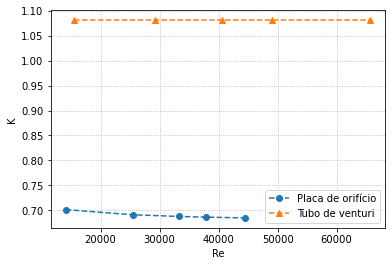

In [55]:
#%matplotlib
fig, ax = plt.subplots()
ax.set(xlabel=r'Re', ylabel=r'K')

ax.plot(placa[3], placa[4], marker='o', ls='--', label='Placa de orifício')
ax.plot(tubo[3], tubo[4], marker='^', ls='--', label='Tubo de venturi')

ax.legend()
ax.grid(ls='dotted')
fig.savefig('Re_x_k.pdf', bbox_inches='tight')

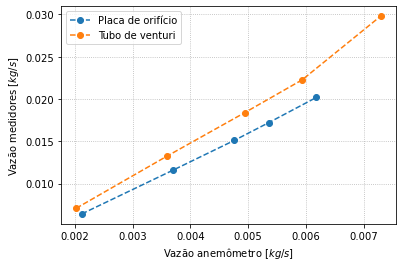

In [57]:
fig, ax = plt.subplots()
ax.set(ylabel=r'Vazão medidores $[kg/s]$', xlabel=r'Vazão anemômetro $[kg/s]$')

ax.plot(df_placa['ve'].values*1.2*np.pi*(0.0257**2)/4, placa[1], marker='o', ls='--', label='Placa de orifício')
ax.plot(df_vent['ve'].values*1.2*np.pi*(0.0244**2)/4, tubo[1], marker='o', ls='--', label='Tubo de venturi')

ax.legend()
ax.grid(ls='dotted')

fig.savefig('comparação_vazão.pdf', bbox_inches='tight')